2024-04-14 02:30:46.958531: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-14 02:30:46.961215: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-14 02:30:46.997658: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-14 02:30:47.707969: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


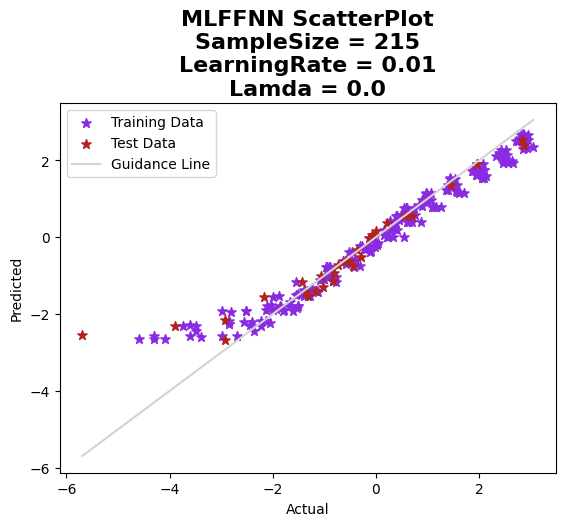

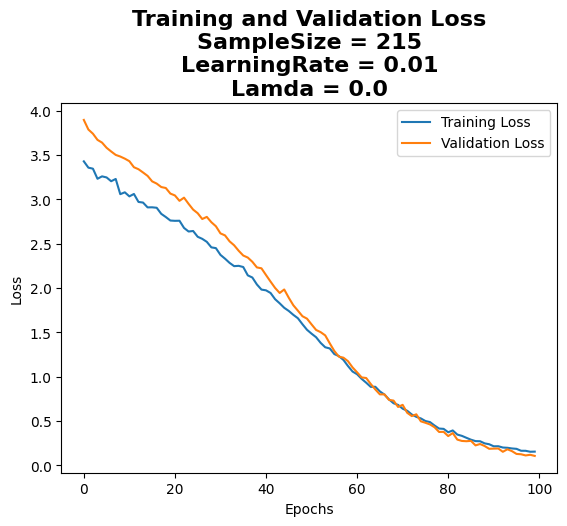

Train Loss: 0.16676580905914307
Validation Loss: 0.10646948218345642
Test Loss: 0.4945839047431946


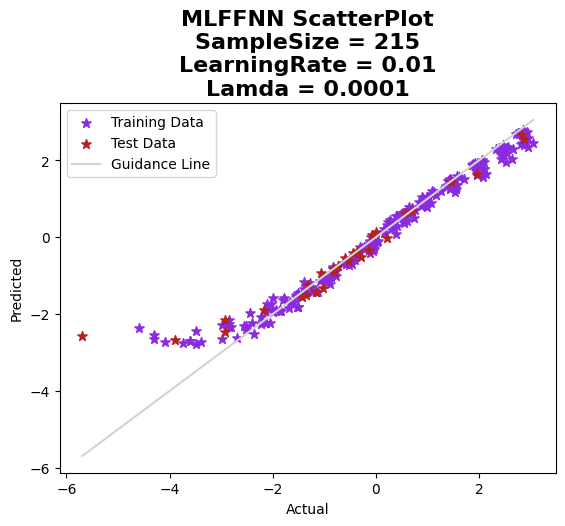

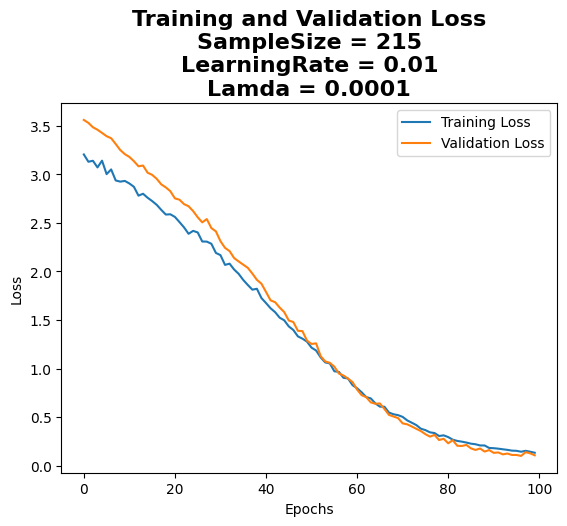

Train Loss: 0.1287221908569336
Validation Loss: 0.1058916300535202
Test Loss: 0.44759422540664673


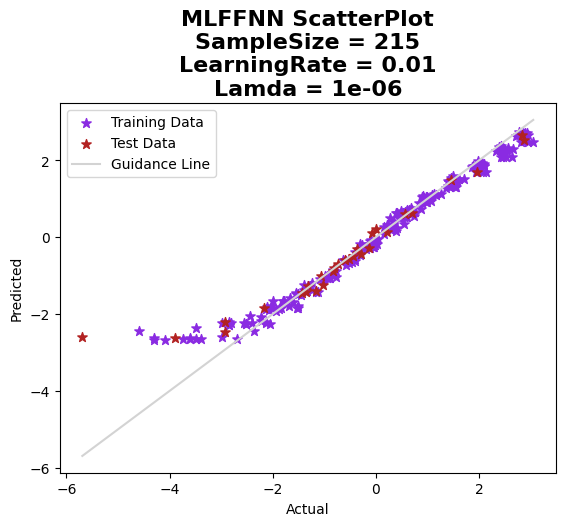

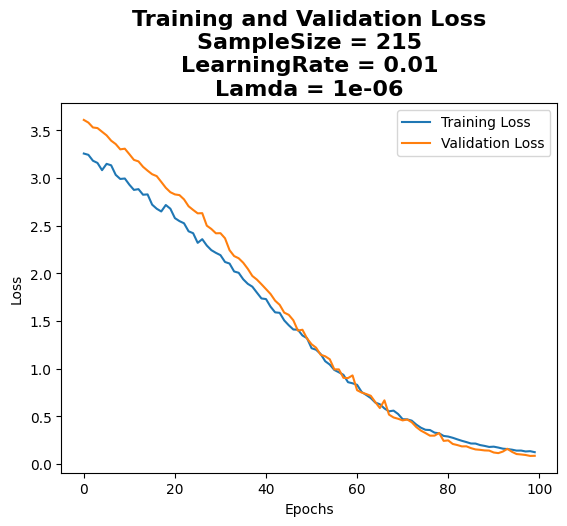

Train Loss: 0.11846160888671875
Validation Loss: 0.08735822141170502
Test Loss: 0.4306659698486328


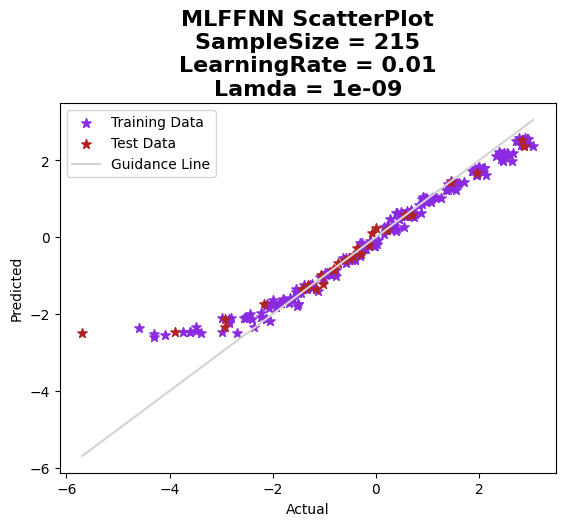

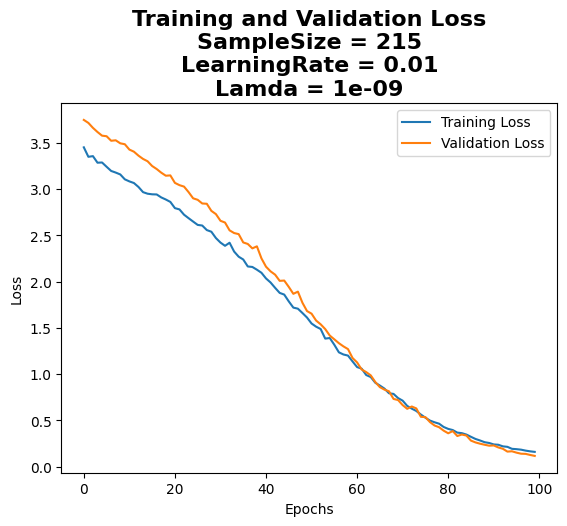

Train Loss: 0.1514776200056076
Validation Loss: 0.11685530841350555
Test Loss: 0.48181870579719543
Index Sample Size  Learning Rate            λ  Train Erms  Validate Erms  Test Erms
    1         215           0.01 0.000000e+00    0.412319       0.327790   0.703267
    2         215           0.01 1.000000e-04    0.353237       0.315262   0.663843
    3         215           0.01 1.000000e-06    0.348588       0.296008   0.656200
    4         215           0.01 1.000000e-09    0.393736       0.342105   0.694132


In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

column_names = [
    "Index",
    "Sample Size",
    "Learning Rate",
    "λ",
    "Train Erms",
    "Validate Erms",
    "Test Erms",
]
table_index = 0
table_df = pd.DataFrame(columns=column_names)


def build_and_train_model(train_x, train_y, val_x, val_y, learning_rate, lamda):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # Define the model architecture
        # Build the model
        model = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(
                    64,
                    activation="tanh",
                    kernel_regularizer=tf.keras.regularizers.L1(lamda),
                    input_shape=(train_x.shape[1],),
                ),
                tf.keras.layers.Dense(1, activation="linear"),
            ]
        )

    # Compile the model with the specified learning rate
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="mean_squared_error")

    # Train the model
    result = model.fit(
        train_x,
        train_y,
        validation_data=(val_x, val_y),
        epochs=100,
        batch_size=32,
        verbose=0,
    )

    return model, result


def evaluate_model(model, x, y):
    loss = model.evaluate(x, y, verbose=0)

    y_pred = model.predict(x, verbose=0)

    return loss, y_pred


def add_data_to_table(
    sample_size, learning_rate, lamda, train_erms, validate_erms, test_erms
):
    row_data = {}
    global table_df
    global table_index
    table_index = table_index + 1
    row_data["Index"] = table_index
    row_data["Sample Size"] = sample_size
    row_data["Learning Rate"] = learning_rate
    row_data["λ"] = lamda
    row_data["Train Erms"] = train_erms
    row_data["Validate Erms"] = validate_erms
    row_data["Test Erms"] = test_erms
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        table_df = pd.concat(
            [table_df, pd.DataFrame(row_data, index=[0])], ignore_index=True
        )


def print_table():
    print(table_df.to_string(index=False))


def get_N(x):
    N = len(x)
    return N


def get_erms(y, t):
    y_mse = tf.reduce_mean(tf.square(t - y))
    erms = np.sqrt(y_mse)
    return erms


def get_meshgrid(start_x1, stop_x1, start_x2, stop_x2, N):
    x1_range = np.linspace(start_x1, stop_x1, N)
    x2_range = np.linspace(start_x2, stop_x2, N)
    x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)

    input_grid = np.column_stack((x1_grid.ravel(), x2_grid.ravel()))

    return (x1_grid, x2_grid, input_grid)


def plot_loss(result, sample_size, learning_rate, lamda):
    # Plot training loss
    plt.plot(result.history["loss"], label="Training Loss")
    plt.plot(result.history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plot_title = (
        "Training and Validation Loss\nSampleSize = "
        + str(sample_size)
        + "\nLearningRate = "
        + str(learning_rate)
        + "\nLamda = "
        + str(lamda)
    )
    plt.title(plot_title, fontsize=16, weight="bold")
    plt.legend()
    # plt.savefig("/home/dipendu/programs/mtech_2023/ml/ass2/trial/reg_3/"+plot_title+'.png')
    plt.show()


def scatter_plot_2d(x, y, x_label, y_label, plot_title, plot_color):
    plt.scatter(x, y, color=plot_color, label=plot_title, marker="*", s=50)
    plt.title(plot_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    # plt.show()


def line_plot(x, y, plot_label, plot_color):
    plt.plot(x, y, color=plot_color, label=plot_label)
    plt.legend()
    # plt.show()


def plot_scatter(
    train_y,
    train_y_pred,
    val_y,
    val_y_pred,
    test_y,
    test_y_pred,
    sample_size,
    learning_rate,
    lamda,
):
    scatter_plot_2d(
        train_y, train_y_pred, "Actual", "Predicted", "Training Data", "blueviolet"
    )

    # scatter_plot_2d(
    #     val_y, val_y_pred, "Actual", "Predicted", "Validation Data", "olivedrab"
    # )

    scatter_plot_2d(
        test_y, test_y_pred, "Actual", "Predicted", "Test Data", "firebrick"
    )

    min_point = min(
        np.min(train_y), np.min(train_y_pred), np.min(test_y), np.min(test_y_pred)
    )
    max_point = max(
        np.max(train_y), np.max(train_y_pred), np.max(test_y), np.max(test_y_pred)
    )

    line_plot(
        (min_point, max_point), (min_point, max_point), "Guidance Line", "lightgray"
    )

    plot_title = (
        "MLFFNN ScatterPlot\nSampleSize = "
        + str(sample_size)
        + "\nLearningRate = "
        + str(learning_rate)
        + "\nLamda = "
        + str(lamda)
    )
    # plt.savefig("/home/dipendu/programs/mtech_2023/ml/ass2/trial/reg_3/"+plot_title+'.png')
    plt.title(plot_title, fontsize=16, weight="bold")
    plt.show()


def plot_graphs(
    train_x,
    train_y,
    val_x,
    val_y,
    test_x,
    test_y,
    sample_size,
    regularization_coefficients,
    learning_rate=0.1,
):
    for lamda in regularization_coefficients:
        model, result = build_and_train_model(
            train_x, train_y, val_x, val_y, learning_rate, lamda
        )

        train_loss, train_y_pred = evaluate_model(model, train_x, train_y)
        val_loss, val_y_pred = evaluate_model(model, val_x, val_y)
        test_loss, test_y_pred = evaluate_model(model, test_x, test_y)

        train_erms = get_erms(train_y_pred, train_y)
        validate_erms = get_erms(val_y_pred, val_y)
        test_erms = get_erms(test_y_pred, test_y)

        # Plot scatter the graphs
        plot_scatter(
            train_y,
            train_y_pred,
            val_y,
            val_y_pred,
            test_y,
            test_y_pred,
            sample_size,
            learning_rate,
            lamda,
        )

        # Plot training loss
        plot_loss(result, sample_size, learning_rate, lamda)

        add_data_to_table(
            sample_size, learning_rate, lamda, train_erms, validate_erms, test_erms
        )

        # Print train loss
        print("Train Loss:", train_loss)
        # Print validation loss
        print("Validation Loss:", val_loss)
        # Print test loss
        print("Test Loss:", test_loss)


def main():
    folder_number = "9"
    current_directory = os.getcwd()
    # regression_dataset_3_path=current_directory+ "/Datasets_for_A1/Regression/Dataset 3/" + folder_number + "/"
    regression_dataset_3_path = (
        "/home/dipendu/programs/mtech_2023/ml/ass2/Datasets_for_A1/Regression/Dataset 3/"
        + folder_number
        + "/"
    )

    regression_dataset_3_Train_data = regression_dataset_3_path + "train_data.csv"
    df = pd.read_csv(regression_dataset_3_Train_data)
    data = df.to_numpy()
    train_x = data

    regression_dataset_3_Train_label = regression_dataset_3_path + "train_label.csv"
    df = pd.read_csv(regression_dataset_3_Train_label)
    data = df.to_numpy()
    train_y = data

    regression_dataset_3_Validation_data = regression_dataset_3_path + "val_data.csv"
    df = pd.read_csv(regression_dataset_3_Validation_data)
    data = df.to_numpy()
    val_x = data

    regression_dataset_3_Validation_label = regression_dataset_3_path + "val_label.csv"
    df = pd.read_csv(regression_dataset_3_Validation_label)
    data = df.to_numpy()
    val_y = data

    regression_dataset_3_Test_data = regression_dataset_3_path + "test_data.csv"
    df = pd.read_csv(regression_dataset_3_Test_data)
    data = df.to_numpy()
    test_x = data

    regression_dataset_3_Test_label = regression_dataset_3_path + "test_label.csv"
    df = pd.read_csv(regression_dataset_3_Test_label)
    data = df.to_numpy()
    test_y = data

    learning_rates = [0.01]
    regularization_coefficients = [0.0, 0.0001, 1e-6, 1e-9]

    sample_size = get_N(train_x)
    for learning_rate in learning_rates:
        plot_graphs(
            train_x,
            train_y,
            val_x,
            val_y,
            test_x,
            test_y,
            sample_size,
            regularization_coefficients,
            learning_rate,
        )

    print_table()


if __name__ == "__main__":
    main()